# Predicting Stock Market Prices using Sentiment Analysis of Tweets.

**NOTE**: Please setup environment according to `requirements.txt` and ensure that Keras's backend is set to `Theano`

Install requirements via command: `pip install -r requirements.txt`

In [1]:
import os
os.environ["KERAS_BACKEND"] = "theano"
import keras.backend
keras.backend.set_image_dim_ordering('th') # keras < 2.2.5
#keras.backend.set_image_data_format('channels_last') # keras >= 2.2.5 & keras < 2.3

Using Theano backend.


In [2]:
import keras
print(f"Keras version: {keras.__version__}")
print(f"Keras Backend: {keras.backend.backend()}")

Keras version: 1.1.0
Keras Backend: theano


In [3]:
# Libraries
import csv
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pylab import cm

import time
from datetime import datetime
from tqdm.auto import tqdm
tqdm.pandas(desc = "Progress")

# NLP
import nltk
from emotion_predictor import EmotionPredictor
from nltk.sentiment import SentimentIntensityAnalyzer
#nltk.download('vader_lexicon')

# Stats Models
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests

# Scikit-learn Models
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, Exponentiation
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier, MLPRegressor

# Scikit-learn Metrics
from sklearn.metrics import roc_auc_score, fbeta_score, make_scorer, accuracy_score, f1_score
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit, GridSearchCV, RandomizedSearchCV

# GBRT
import xgboost as xgb
import lightgbm as lgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# This is the pipeline module we need from imblearn for Undersampling
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Feature Importance
import shap 

pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 99)
pd.set_option('display.float_format', lambda x : f'{x:.4f}')
mpl.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16
plt.rcParams['axes.linewidth'] = 2
colors = cm.get_cmap('tab20', 10)

SEED = 4222
np.random.seed(SEED)

# Part 0: Augmented VADER with Loughran-McDonald
VADER is focused on social media and short texts, hence we augment the lexicon with additional sentiment and word lists from the Loughran-McDonald Financial Sentiment Word List.

In [4]:
# stock market lexicon
stock_lex = pd.read_csv('./lexicon/stock_lex.csv')
stock_lex['sentiment'] = (stock_lex['Aff_Score'] + stock_lex['Neg_Score'])/2
stock_lex = dict(zip(stock_lex.Item, stock_lex.sentiment))
stock_lex = {k:v for k,v in stock_lex.items() if len(k.split(' '))==1}
stock_lex_scaled = {}
for k, v in stock_lex.items():
    if v > 0:
        stock_lex_scaled[k] = v / max(stock_lex.values()) * 4
    else:
        stock_lex_scaled[k] = v / min(stock_lex.values()) * -4

In [5]:
sia = SentimentIntensityAnalyzer()
# Loughran and McDonald
positive = []
with open('./lexicon/lm_positive.csv', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        positive.append(row[0].strip())
    
negative = []
with open('./lexicon/lm_negative.csv', 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        entry = row[0].strip().split(" ")
        if len(entry) > 1:
            negative.extend(entry)
        else:
            negative.append(entry[0])

final_lex = {}
final_lex.update({word:2.0 for word in positive})
final_lex.update({word:-2.0 for word in negative})
final_lex.update(stock_lex_scaled)
final_lex.update(sia.lexicon)
sia.lexicon = final_lex

# Part 1: Twitter Data Import and Cleaning

Data is imported in a csv format and assumed to be scraped using Tweepy's API. See notebook on scraping data for more information.

In [6]:
# Import Dataset
tweets = pd.read_csv("./data/rich_tweets.csv", low_memory=False)
tweets.head()

Unnamed: 0                      created_at                   id  \
0          0  Fri Apr 02 17:03:10 +0000 2021  1378030258692055042   
1          1  Thu Apr 01 20:38:26 +0000 2021  1377722043584503808   
2          2  Wed Mar 31 18:47:05 +0000 2021  1377331633024425987   
3          3  Mon Mar 29 16:30:37 +0000 2021  1376572513195413505   
4          4  Fri Mar 26 18:50:20 +0000 2021  1375520512651063297   

                id_str                                               text  \
0  1378030258692055042  The best way to prevent new variants from emer...   
1  1377722043584503808  It's encouraging to see innovation and clean e...   
2  1377331633024425987  Here are five things you should know if you wa...   
3  1376572513195413505  The technological transformation we need to ad...   
4  1375520512651063297  I had a great time answering questions about m...   

  truncated                                           entities  \
0      True  {'hashtags': [], 'symbols': [], 'user_mentions...   
1      True  {'hashtags': [{'text': 'AmericanJobsPlan', 'in...   
2      True  {'hashtags': [], 'symbols': [], 'user_mentions...   
3      True  {'hashtags': [], 'symbols': [], 'user_mentions...   
4      True  {'hashtags': [], 'symbols': [], 'user_mentions...   

                                              source  in_reply_to_status_id  \
0  <a href="https://mobile.twitter.com" rel="nofo...                    nan   
1  <a href="https://mobile.twitter.com" rel="nofo...                    nan   
2  <a href="https://mobile.twitter.com" rel="nofo...                    nan   
3  <a href="https://mobile.twitter.com" rel="nofo...                    nan   
4  <a href="https://mobile.twitter.com" rel="nofo...                    nan   

  in_reply_to_status_id_str  in_reply_to_user_id  in_reply_to_user_id_str  \
0                       NaN                  nan                      nan   
1                       NaN                  nan                      nan   
2                       NaN                  nan                      nan   
3                       NaN                  nan                      nan   
4                       NaN                  nan                      nan   

   in_reply_to_screen_name                                               user  \
0                      nan  {'id': 50393960, 'id_str': '50393960', 'name':...   
1                      nan  {'id': 50393960, 'id_str': '50393960', 'name':...   
2                      nan  {'id': 50393960, 'id_str': '50393960', 'name':...   
3                      nan  {'id': 50393960, 'id_str': '50393960', 'name':...   
4                      nan  {'id': 50393960, 'id_str': '50393960', 'name':...   

   geo coordinates place contributors is_quote_status retweet_count  \
0  NaN         NaN   NaN          NaN           False           895   
1  NaN         NaN   NaN          NaN           False           445   
2  NaN         NaN   NaN          NaN           False           519   
3  NaN         NaN   NaN          NaN           False           625   
4  NaN         NaN   NaN          NaN           False           381   

  favorite_count favorited retweeted possibly_sensitive lang  \
0           4561     False     False              False   en   
1           3734     False     False              False   en   
2           2507     False     False              False   en   
3           4252     False     False              False   en   
4           3765     False     False              False   en   

  extended_entities  quoted_status_id  quoted_status_id_str quoted_status  \
0               NaN               nan                   nan           NaN   
1               NaN               nan                   nan           NaN   
2               NaN               nan                   nan           NaN   
3               NaN               nan                   nan           NaN   
4               NaN               nan                   nan           NaN   

  withheld_scope withheld_c

In [7]:
# Filter out unnecessary columns
tweets = tweets[['created_at', 'text', 'retweet_count', 'favorite_count']]
tweets.head()

created_at  \
0  Fri Apr 02 17:03:10 +0000 2021   
1  Thu Apr 01 20:38:26 +0000 2021   
2  Wed Mar 31 18:47:05 +0000 2021   
3  Mon Mar 29 16:30:37 +0000 2021   
4  Fri Mar 26 18:50:20 +0000 2021   

                                                text retweet_count  \
0  The best way to prevent new variants from emer...           895   
1  It's encouraging to see innovation and clean e...           445   
2  Here are five things you should know if you wa...           519   
3  The technological transformation we need to ad...           625   
4  I had a great time answering questions about m...           381   

  favorite_count  
0           4561  
1           3734  
2           2507  
3           4252  
4           3765

## Preprocessing of Tweets
Retain:
1. Capitals
2. Emoticons
3. Contractions
4. Punctuations
5. Stopwords 

As these terms above contain the ability to influence sentiment scores, and can be adequately handled by sentiment analysis tools

Drop:
1. Twitter handles
2. '#' from hashtags
3. Remove URLs (https:\\\\)
4. Line breaks in Tweets
5. Trailing white spaces that may arise from above preprocessing steps

In [8]:
# Remove Twitter Handles
tweets['text'] = tweets['text'].str.replace(r'@[^\s]+ ','')
# Remove URLs
tweets['text'] = tweets['text'].str.replace(r'http\S+','')
tweets['text'] = tweets['text'].str.replace(r't.co\S+','')
# Strip # from hashtags
tweets['text'] = tweets['text'].str.replace('#', '')
# Line breaks
tweets['text'] = tweets['text'].str.replace('\n', ' ')
# Trailing white spaces
tweets['text'] = tweets['text'].str.rstrip() 
tweets.tail()

created_at  \
21438  Thu Oct 18 16:11:32 +0000 2018   
21439  Thu Oct 18 16:08:25 +0000 2018   
21440  Thu Oct 18 05:22:47 +0000 2018   
21441  Wed Oct 17 21:50:13 +0000 2018   
21442  Wed Jun 06 22:50:15 +0000 2012   

                                                    text retweet_count  \
21438  St. Louis got to see this first! And I’m excit...            85   
21439  After 9 years, we finally have a simple way to...           282   
21440  Thompson: Why Stephen Curry should be, even wa...            25   
21441                         Thank you ⁦Congrats again.            27   
21442  Oracle's got 100+ enterprise applications live...          1010   

      favorite_count  
21438            415  
21439           1594  
21440            107  
21441            252  
21442           1461

In [9]:
# Clean Datatypes
# Drop NaNs
tweets = tweets.dropna()

# Convert all counts to numeric
tweets['retweet_count'] = tweets['retweet_count'].progress_map(lambda x: x if str(x).isnumeric() else 0)
tweets['favorite_count'] = tweets['favorite_count'].progress_map(lambda x: x if str(x).isnumeric() else 0)

# Set Type of Retweet Count and Favorite Count
tweets[['retweet_count', 'favorite_count']] = tweets[['retweet_count', 'favorite_count']].astype('int32')

# Convert Datetime to Date
tweets['created_at'] = tweets['created_at'].progress_map(lambda date: datetime.strptime(date, '%a %b %d %H:%M:%S %z %Y').date())

Progress:   0%|          | 0/21435 [00:00<?, ?it/s]

Progress:   0%|          | 0/21435 [00:00<?, ?it/s]

Progress:   0%|          | 0/21435 [00:00<?, ?it/s]

## Part 1b: Stock Market Data Import and Cleaning

The Stock Market data consists of the Open, High, Low and Close prices daily. For this analysis
we will only be using the Closing values data.

Since the data is a time series, values are inherently affected by past lags of itself. In this analysis,
we are interested in finding the effects of emotions and sentiments on day to day changes of stock market
prices. As such, we difference the series accordingly to remove trends and focus on unit changes.

In [10]:
# Import Dataset
stock_data = pd.read_csv("./data/S&P500.csv", parse_dates=['Date'], infer_datetime_format=True)
stock_data = pd.merge(stock_data[['Date']], stock_data.shift(1).drop(['Date'], axis=1), left_index=True, right_index=True, suffixes=('', '_lag_1'))
stock_data

Date      Open      High       Low     Close
0    2021-04-01       nan       nan       nan       nan
1    2021-03-31 3992.7800 4020.6300 3992.7800 4019.8700
2    2021-03-30 3967.2500 3994.4100 3966.9800 3972.8900
3    2021-03-29 3963.3400 3968.0100 3944.3500 3958.5500
4    2021-03-26 3969.3100 3981.8300 3943.2500 3971.0900
5    2021-03-25 3917.1200 3978.1900 3917.1200 3974.5400
6    2021-03-24 3879.3400 3919.5400 3853.5000 3909.5200
...         ...       ...       ...       ...       ...
1818 2014-01-10 1841.2600 1843.4500 1815.5200 1819.2000
1819 2014-01-09 1840.0600 1843.1500 1832.4300 1842.3700
1820 2014-01-08 1839.0000 1843.2300 1830.3800 1838.1300
1821 2014-01-07 1837.9000 1840.0200 1831.4000 1837.4900
1822 2014-01-06 1828.7100 1840.1000 1828.7100 1837.8800
1823 2014-01-03 1832.3100 1837.1600 1823.7300 1826.7700
1824 2014-01-02 1833.2100 1838.2400 1829.1300 1831.3700

[1825 rows x 5 columns]

In [11]:
# Convert Date column to standardized Date and keep Date and Close columns only
#stock_data.columns = ['Date', 'Open', 'High', 'Low', 'Close']
#stock_data.index = stock_data['Date'].map(lambda date: datetime.strptime(date, "%m/%d/%y").date())
stock_data = stock_data.set_index('Date')[['Close']].dropna()
stock_data

Close
Date                
2021-03-31 4019.8700
2021-03-30 3972.8900
2021-03-29 3958.5500
2021-03-26 3971.0900
2021-03-25 3974.5400
2021-03-24 3909.5200
2021-03-23 3889.1400
...              ...
2014-01-10 1819.2000
2014-01-09 1842.3700
2014-01-08 1838.1300
2014-01-07 1837.4900
2014-01-06 1837.8800
2014-01-03 1826.7700
2014-01-02 1831.3700

[1824 rows x 1 columns]

ADF Test p-value: 0.17932996175233173


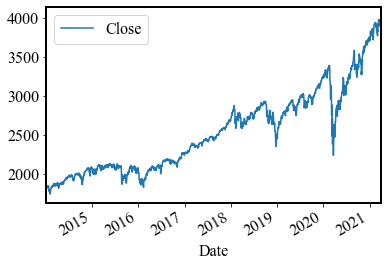

In [12]:
# Inspection of Time Series Data
stock_data.plot(y = "Close")
print(f"ADF Test p-value: {adfuller(stock_data['Close'])[1]}")

ADF Test p-value: 2.2652630146446078e-24


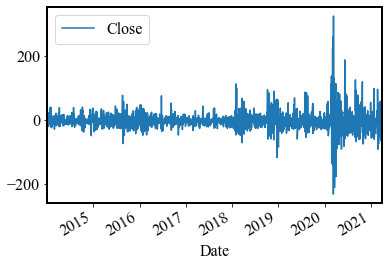

In [13]:
# Clear Trend Observed and ADF test failed to reject null hypothesis -> Series is not stationary
stock_data['Close'] = stock_data['Close'].diff()
stock_data = stock_data.dropna()

stock_data.plot(y = "Close")
print(f"ADF Test p-value: {adfuller(stock_data['Close'])[1]}")

# Part 2: Exploratory Data Analysis

Progress:   0%|          | 0/21435 [00:00<?, ?it/s]

<AxesSubplot:title={'center':'Number of characters per Tweet'}, ylabel='Frequency'>

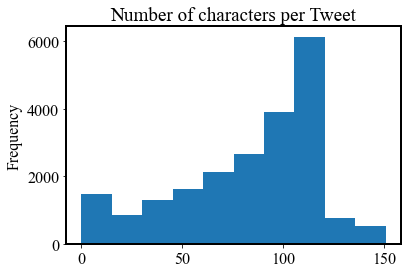

In [14]:
tweets['text'].progress_map(len).plot(kind = "hist", title = "Number of characters per Tweet")

Progress:   0%|          | 0/21435 [00:00<?, ?it/s]

Progress:   0%|          | 0/21435 [00:00<?, ?it/s]

<AxesSubplot:title={'center':'Number of Words per Tweet'}, ylabel='Frequency'>

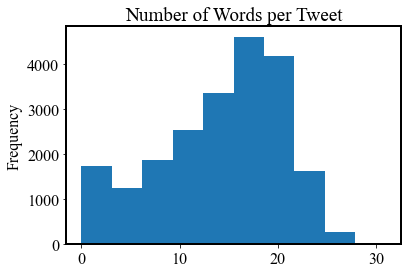

In [15]:
tweets['text'].progress_map(str.split).progress_map(len).plot(kind = "hist", title = "Number of Words per Tweet")

<AxesSubplot:title={'center':'Number of tweets per day'}, xlabel='created_at'>

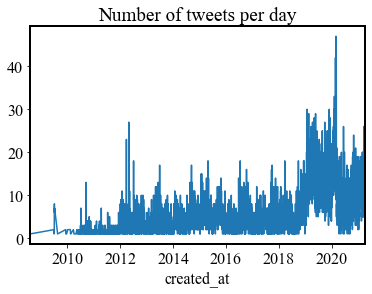

In [16]:
tweets.groupby('created_at').size().plot(title = "Number of tweets per day")

## Part 2b: Post EDA Processing 

Insight 1: Sparse number of tweets before 2012.

* Since the number of tweets before 2012 is sparse, we trim the tweets data to 2012 onwards.

Insight 2: Correlation between Retweets and Favorites

* A high correlation between number of retweets and number of favorites indicate that new features
generated from a combination of the 2 is likely unnecessary.

In [17]:
tweets = tweets[tweets['created_at'] > datetime.strptime("2012", "%Y").date()]
tweets.head()

created_at                                               text  \
0  2021-04-02  The best way to prevent new variants from emer...   
1  2021-04-01  It's encouraging to see innovation and clean e...   
2  2021-03-31  Here are five things you should know if you wa...   
3  2021-03-29  The technological transformation we need to ad...   
4  2021-03-26  I had a great time answering questions about m...   

   retweet_count  favorite_count  
0            895            4561  
1            445            3734  
2            519            2507  
3            625            4252  
4            381            3765

# Part 3: Feature Engineering

We use 2 main forms of feature engineering using NLP techniques:

1. Emotions
2. Sentiment Polarity

Additionally, we use a weighted form of the features above to give more significance to popular tweets that are likely to be more influential.

In [18]:
%%time
# https://stackoverflow.com/questions/53423610/how-to-update-scan-cython-code-in-theano
model = EmotionPredictor(classification='ekman', setting='mc') 
tweet_emotions = model.predict_probabilities(tweets['text'])

emotions = ['Anger', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise']
tweet_emotions.columns = ["Tweet"] + emotions

tweets = tweets.join(tweet_emotions.drop('Tweet', axis = 1))

Wall time: 3min 36s


In [19]:
tweets.head()

created_at                                               text  \
0  2021-04-02  The best way to prevent new variants from emer...   
1  2021-04-01  It's encouraging to see innovation and clean e...   
2  2021-03-31  Here are five things you should know if you wa...   
3  2021-03-29  The technological transformation we need to ad...   
4  2021-03-26  I had a great time answering questions about m...   

   retweet_count  favorite_count  Anger  Disgust   Fear    Joy  Sadness  \
0            895            4561 0.0252   0.0107 0.2534 0.5359   0.0332   
1            445            3734 0.0013   0.0003 0.0157 0.9093   0.0047   
2            519            2507 0.0352   0.0122 0.7514 0.0346   0.0531   
3            625            4252 0.0152   0.0008 0.0145 0.8927   0.0154   
4            381            3765 0.0649   0.0047 0.0578 0.7713   0.0619   

   Surprise  
0    0.1416  
1    0.0688  
2    0.1135  
3    0.0613  
4    0.0394

In [20]:
tweet_ = tweets[['created_at', 'text', 'Anger', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise']].copy()
print(tweet_.shape)
tweet_.head()

(20794, 8)


created_at                                               text  Anger  \
0  2021-04-02  The best way to prevent new variants from emer... 0.0252   
1  2021-04-01  It's encouraging to see innovation and clean e... 0.0013   
2  2021-03-31  Here are five things you should know if you wa... 0.0352   
3  2021-03-29  The technological transformation we need to ad... 0.0152   
4  2021-03-26  I had a great time answering questions about m... 0.0649   

   Disgust   Fear    Joy  Sadness  Surprise  
0   0.0107 0.2534 0.5359   0.0332    0.1416  
1   0.0003 0.0157 0.9093   0.0047    0.0688  
2   0.0122 0.7514 0.0346   0.0531    0.1135  
3   0.0008 0.0145 0.8927   0.0154    0.0613  
4   0.0047 0.0578 0.7713   0.0619    0.0394

## Part 3b: New Feature EDA

Here we aim to find insights regarding the new features created that will help us to 
draw insights and better understand any results found later on.

In [21]:
agg_mean = tweet_.groupby(['created_at']).agg({
    'Anger': 'mean',
    'Disgust': 'mean',
    'Fear': 'mean',
    'Joy': 'mean',
    'Sadness': 'mean',
    'Surprise': 'mean'
}).reset_index()
agg_mean.head()

created_at  Anger  Disgust   Fear    Joy  Sadness  Surprise
0  2012-01-02 0.0071   0.0008 0.0511 0.7048   0.0179    0.2182
1  2012-01-03 0.0145   0.0092 0.3649 0.3674   0.0455    0.1985
2  2012-01-04 0.1113   0.0038 0.3495 0.2448   0.0153    0.2753
3  2012-01-05 0.0164   0.0032 0.0813 0.4238   0.0387    0.4366
4  2012-01-06 0.0062   0.0010 0.0444 0.6359   0.0207    0.2918

In [22]:
# https://stackoverflow.com/questions/45281297/group-by-week-in-pandas/45281439
agg_mean['created_at'] = pd.to_datetime(agg_mean['created_at'], infer_datetime_format=True)
#agg['lag_1w'] = pd.to_datetime(agg['lag_1w']) - pd.to_timedelta(7, unit='d')
agg_mean = agg_mean.groupby([pd.Grouper(key='created_at', freq='W')]).agg({
    'Anger': 'mean',
    'Disgust': 'mean',
    'Fear': 'mean',
    'Joy': 'mean',
    'Sadness': 'mean',
    'Surprise': 'mean'
})
agg_mean.tail()

Anger  Disgust   Fear    Joy  Sadness  Surprise
created_at                                                 
2021-03-07 0.0301   0.0196 0.1937 0.4234   0.1010    0.2323
2021-03-14 0.0474   0.0226 0.1677 0.4173   0.1010    0.2439
2021-03-21 0.0573   0.0272 0.2178 0.3836   0.1007    0.2134
2021-03-28 0.0391   0.0244 0.2001 0.4307   0.0821    0.2236
2021-04-04 0.0481   0.0146 0.1522 0.4105   0.0751    0.2995

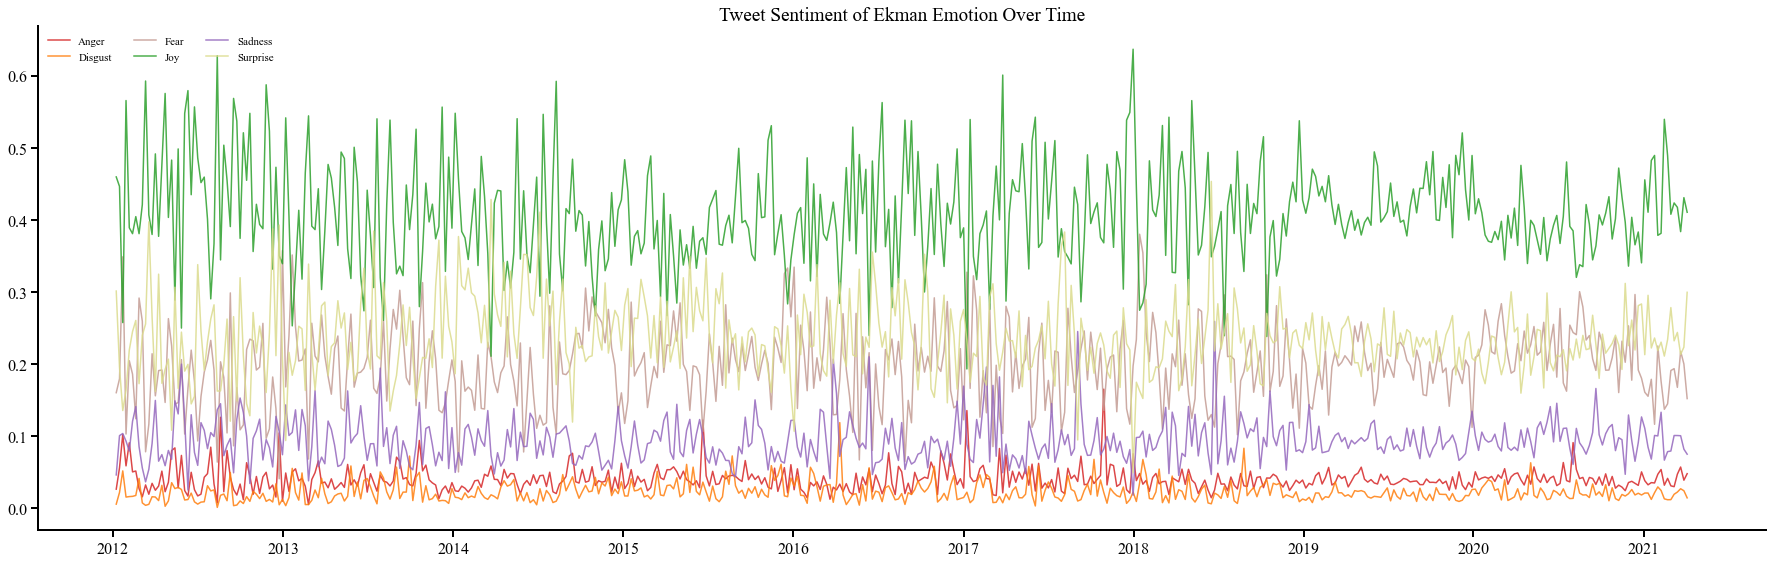

In [23]:
fig = plt.figure(figsize=(24,7))
ax = fig.add_axes([0,0,1,1])
ax.xaxis.set_tick_params(which='both', size=7, width=2, direction='out')
ax.yaxis.set_tick_params(which='both', size=7, width=2, direction='out')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.plot(agg_mean['Anger'], linewidth=1.5, alpha=0.85, color=colors(3), label='Anger') # Red
ax.plot(agg_mean['Disgust'], linewidth=1.5, alpha=0.85, color=colors(1), label='Disgust') # Orange
ax.plot(agg_mean['Fear'], linewidth=1.5, alpha=0.85, color=colors(5), label='Fear') # Brown
ax.plot(agg_mean['Joy'], linewidth=1.5, alpha=0.85, color=colors(2), label='Joy') # Green
ax.plot(agg_mean['Sadness'], linewidth=1.5, alpha=0.85, color=colors(4), label='Sadness') # Purple
ax.plot(agg_mean['Surprise'], linewidth=1.5, alpha=0.85, color=colors(8), label='Surprise') # Yellow
ax.spines['bottom']
ax.spines['top']
ax.tick_params(axis='y')
ax.tick_params(axis='y')
ax.set_title('Tweet Sentiment of Ekman Emotion Over Time')
leg = plt.legend(framealpha = 0, loc='upper left', ncol=3, frameon=False, fontsize=11)

In [24]:
tweet_sentiments = tweets['text'].progress_map(sia.polarity_scores)

sentiments = ['neg', 'neu', 'pos', 'compound']
tweets[sentiments] = tweet_sentiments.progress_apply(pd.Series)

tweets.head()

Progress:   0%|          | 0/20794 [00:00<?, ?it/s]

Progress:   0%|          | 0/20794 [00:00<?, ?it/s]

created_at                                               text  \
0  2021-04-02  The best way to prevent new variants from emer...   
1  2021-04-01  It's encouraging to see innovation and clean e...   
2  2021-03-31  Here are five things you should know if you wa...   
3  2021-03-29  The technological transformation we need to ad...   
4  2021-03-26  I had a great time answering questions about m...   

   retweet_count  favorite_count  Anger  Disgust   Fear    Joy  Sadness  \
0            895            4561 0.0252   0.0107 0.2534 0.5359   0.0332   
1            445            3734 0.0013   0.0003 0.0157 0.9093   0.0047   
2            519            2507 0.0352   0.0122 0.7514 0.0346   0.0531   
3            625            4252 0.0152   0.0008 0.0145 0.8927   0.0154   
4            381            3765 0.0649   0.0047 0.0578 0.7713   0.0619   

   Surprise    neg    neu    pos  compound  
0    0.1416 0.2910 0.2170 0.4920    0.7676  
1    0.0688 0.2310 0.2280 0.5410    0.8688  
2    0.1135 0.1920 0.4170 0.3910    0.3133  
3    0.0613 0.1720 0.2530 0.5760    0.8219  
4    0.0394 0.1010 0.2840 0.6160    0.7092

In [25]:
weighted_emotions = ["weighted_" + emotion for emotion in emotions]
for emotion in emotions:
    tweets["weighted_" + emotion] = tweets[emotion] * (tweets['favorite_count'] + 1)

weighted_sentiments = ["weighted_" + sentiment for sentiment in sentiments]
for sentiment in sentiments:
    tweets["weighted_" + sentiment] = tweets[sentiment] * (tweets['favorite_count'] + 1)

tweets.head()

created_at                                               text  \
0  2021-04-02  The best way to prevent new variants from emer...   
1  2021-04-01  It's encouraging to see innovation and clean e...   
2  2021-03-31  Here are five things you should know if you wa...   
3  2021-03-29  The technological transformation we need to ad...   
4  2021-03-26  I had a great time answering questions about m...   

   retweet_count  favorite_count  Anger  Disgust   Fear    Joy  Sadness  \
0            895            4561 0.0252   0.0107 0.2534 0.5359   0.0332   
1            445            3734 0.0013   0.0003 0.0157 0.9093   0.0047   
2            519            2507 0.0352   0.0122 0.7514 0.0346   0.0531   
3            625            4252 0.0152   0.0008 0.0145 0.8927   0.0154   
4            381            3765 0.0649   0.0047 0.0578 0.7713   0.0619   

   Surprise    neg    neu    pos  compound  weighted_Anger  weighted_Disgust  \
0    0.1416 0.2910 0.2170 0.4920    0.7676        114.8849           48.7579   
1    0.0688 0.2310 0.2280 0.5410    0.8688          4.7463            1.0512   
2    0.1135 0.1920 0.4170 0.3910    0.3133         88.2844           30.7141   
3    0.0613 0.1720 0.2530 0.5760    0.8219         64.6061            3.5455   
4    0.0394 0.1010 0.2840 0.6160    0.7092        244.4600           17.6950   

   weighted_Fear  weighted_Joy  weighted_Sadness  weighted_Surprise  \
0      1156.1939     2444.9482          151.2791           645.9361   
1        58.6743     3396.3692           17.3768           256.7821   
2      1884.5426       86.7180          133.1410           284.5998   
3        61.8367     3796.5639           65.5379           260.9098   
4       217.5096     2904.8351          233.2566           148.2436   

   weighted_neg  weighted_neu  weighted_pos  weighted_compound  
0     1327.5420      989.9540     2244.5040          3501.7912  
1      862.7850      851.5800     2020.6350          3244.9680  
2      481.5360     1045.8360      980.6280           785.7564  
3      731.5160     1076.0090     2449.7280          3495.5407  
4      380.3660     1069.5440     2319.8560          2670.8472

## Part 3b: Post Feature Engineering Processing

In order to compare tweet data against the stock market data, we need to aggregate data by day.

We also need to ensure that all series of values are stationary.

In [26]:
features = emotions + sentiments + weighted_emotions + weighted_sentiments
aggregate_dict = {feature:'mean' for feature in features}

aggregated_tweets = tweets.groupby('created_at').aggregate(aggregate_dict)
aggregated_tweets.head()

Anger  Disgust   Fear    Joy  Sadness  Surprise    neg    neu  \
created_at                                                                  
2012-01-02 0.0071   0.0008 0.0511 0.7048   0.0179    0.2182 0.2640 0.0823   
2012-01-03 0.0145   0.0092 0.3649 0.3674   0.0455    0.1985 0.3357 0.1440   
2012-01-04 0.1113   0.0038 0.3495 0.2448   0.0153    0.2753 0.2534 0.1778   
2012-01-05 0.0164   0.0032 0.0813 0.4238   0.0387    0.4366 0.2632 0.2233   
2012-01-06 0.0062   0.0010 0.0444 0.6359   0.0207    0.2918 0.1625 0.2755   

              pos  compound  weighted_Anger  weighted_Disgust  weighted_Fear  \
created_at                                                                     
2012-01-02 0.6537    0.7933          0.1074            0.0203         0.2825   
2012-01-03 0.5205    0.1964          0.4426            0.3186        10.8244   
2012-01-04 0.5686    0.4291          1.4362            0.0528         6.3537   
2012-01-05 0.5135    0.4296          0.7461            0.1171         1.6834   
2012-01-06 0.5620    0.8092          0.2619            0.0423         1.7916   

            weighted_Joy  weighted_Sadness  weighted_Surprise  weighted_neg  \
created_at                                                                    
2012-01-02       19.1038            0.4658             6.0202        7.6880   
2012-01-03       13.1661            1.5488             4.4494       10.3740   
2012-01-04        3.8223            0.2034             7.1315        4.2206   
2012-01-05       39.3631            1.5008            23.0896       16.2757   
2012-01-06       35.5567            1.5433            11.0541       13.0008   

            weighted_neu  weighted_pos  weighted_compound  
created_at                                                 
2012-01-02        1.7540       16.5580            18.5827  
2012-01-03        4.3283       16.0520             6.1811  
2012-01-04        3.7922       10.9824             8.4967  
2012-01-05       10.4845       39.7398            42.1931  
2012-01-06       12.3785       24.8708            35.3277

In [27]:
# Ensure all features are stationary
for feature in features:
    adf_test = adfuller(aggregated_tweets[feature])[1]

    print(f"ADF test for {feature}, p-value: {adf_test}")

    while adf_test > 0.05:
        aggregated_tweets[feature] = aggregated_tweets[feature].diff()
        aggregated_tweets = aggregated_tweets.dropna()
        print(f"{feature} differenced once")

        adf_test = adfuller(aggregated_tweets[feature])[1]
        print(f"ADF test for {feature}, p-value: {adf_test}")

ADF test for Anger, p-value: 4.150353313775869e-30
ADF test for Disgust, p-value: 0.0
ADF test for Fear, p-value: 0.0
ADF test for Joy, p-value: 0.0
ADF test for Sadness, p-value: 0.0
ADF test for Surprise, p-value: 2.6182577377910028e-14
ADF test for neg, p-value: 3.346012750238899e-18
ADF test for neu, p-value: 0.0
ADF test for pos, p-value: 0.0002136986242774939
ADF test for compound, p-value: 5.8482113163792e-11
ADF test for weighted_Anger, p-value: 0.35500199082226735
weighted_Anger differenced once
ADF test for weighted_Anger, p-value: 2.1982144493003881e-29
ADF test for weighted_Disgust, p-value: 3.0383835201374905e-05
ADF test for weighted_Fear, p-value: 0.41678390994477327
weighted_Fear differenced once
ADF test for weighted_Fear, p-value: 2.2746871356623064e-29
ADF test for weighted_Joy, p-value: 0.014682349407687374
ADF test for weighted_Sadness, p-value: 0.028392887091446384
ADF test for weighted_Surprise, p-value: 0.026521587572644573
ADF test for weighted_neg, p-value: 0.

In [28]:
# Merge Data
merged_data = pd.merge(aggregated_tweets, stock_data, left_index = True, right_index = True)
merged_data.head()

Anger  Disgust   Fear    Joy  Sadness  Surprise    neg    neu  \
2021-03-30 0.0239   0.0075 0.1424 0.5392   0.0511    0.2359 0.2682 0.3925   
2021-03-29 0.0298   0.0076 0.2016 0.4958   0.1066    0.1585 0.2082 0.3512   
2021-03-26 0.0655   0.0171 0.1420 0.4372   0.1339    0.2043 0.2242 0.2772   
2021-03-25 0.0478   0.0633 0.1979 0.3976   0.0896    0.2038 0.1458 0.3309   
2021-03-24 0.0404   0.0395 0.2207 0.4371   0.1069    0.1553 0.1486 0.1814   

              pos  compound  weighted_Anger  weighted_Disgust  weighted_Fear  \
2021-03-30 0.3394    0.2838        199.6129           68.5652      1175.3412   
2021-03-29 0.4412    0.4953      -5277.8383            3.3542     -5451.2160   
2021-03-26 0.4988    0.4995      -7198.4950           18.8160    -17712.6422   
2021-03-25 0.4518    0.1827      -2601.8065         1000.1336      8967.3753   
2021-03-24 0.4478    0.3965       1278.1603         2155.0538    -28940.9299   

            weighted_Joy  weighted_Sadness  weighted_Surprise  weighted_neg  \
2021-03-30    24980.6777         1575.1327         32250.5169    16366.3071   
2021-03-29      686.5788           28.5964            94.3174      168.7235   
2021-03-26      501.1079           88.9971           172.1576      178.9466   
2021-03-25    17355.6953        18974.2257         25120.1736    12812.0292   
2021-03-24    36389.5957        10941.2373         32027.7588       29.8329   

            weighted_neu  weighted_pos  weighted_compound    Close  
2021-03-30    26026.6995    17730.9623         18898.0069 -46.9800  
2021-03-29   -52219.5370      511.3448           701.2656 -14.3400  
2021-03-26   -39585.7066      554.5351           527.3731  12.5400  
2021-03-25    28497.5553    34645.2544        -16238.6128   3.4500  
2021-03-24     3750.2159    88890.7849         43038.7234 -65.0200

# Part 4: Feature Selection (For Hypothesis 1)

In Hypothesis 1, we hypothesise that the emotions and sentiments of twitter tweets will be able to directly predict
the increase/decrease of prices of the stock market. We thus find features that Granger Cause closing values and 
regress them against the differenced closing prices.

In [29]:
# Test method to automatically include all features with high confidence of Granger Causality
selected_features = []

shifted_data = merged_data.copy()
shifted_data['Close'] = shifted_data['Close'].map(lambda x: 0 if x < 0 else 1)

# For each feature in features list, if its is granger causal on Close, append feature name + lags to the selected list
for feature in features:
    granger_causality = grangercausalitytests(shifted_data[['Close', feature]], maxlag = 3, verbose = False)
    for (i, result) in enumerate(granger_causality.items()):
        p_value = result[1][0]['ssr_ftest'][1]
        if p_value < 0.05:
            print(f"{feature} affects Close at lag {result[0]}, pvalue = {p_value}")
            selected_features.append({'feature': feature, 'lag': i + 1})

# Add columns for each selected feature and shift it by number of lags
for selected_feature in selected_features:
    column_name = selected_feature['feature'] + str(selected_feature['lag'])
    shifted_data[column_name] = shifted_data[selected_feature['feature']].shift(selected_feature['lag'])
shifted_data = shifted_data.dropna()

shifted_data.head()

weighted_Disgust affects Close at lag 3, pvalue = 0.013768737074594486


Anger  Disgust   Fear    Joy  Sadness  Surprise    neg    neu  \
2021-03-25 0.0478   0.0633 0.1979 0.3976   0.0896    0.2038 0.1458 0.3309   
2021-03-24 0.0404   0.0395 0.2207 0.4371   0.1069    0.1553 0.1486 0.1814   
2021-03-23 0.0473   0.0151 0.2442 0.4478   0.0799    0.1658 0.2472 0.2239   
2021-03-22 0.0228   0.0123 0.3042 0.3597   0.0389    0.2621 0.2849 0.3093   
2021-03-19 0.0941   0.0432 0.2915 0.2728   0.0977    0.2007 0.2723 0.3005   

              pos  compound  weighted_Anger  weighted_Disgust  weighted_Fear  \
2021-03-25 0.4518    0.1827      -2601.8065         1000.1336      8967.3753   
2021-03-24 0.4478    0.3965       1278.1603         2155.0538    -28940.9299   
2021-03-23 0.2790    0.1317       8552.0719         1121.8638     37581.0888   
2021-03-22 0.4056    0.2656          5.3329           15.1859       -44.2058   
2021-03-19 0.3440    0.1582        380.4771          237.8482     -2855.8424   

            weighted_Joy  weighted_Sadness  weighted_Surprise  weighted_neg  \
2021-03-25    17355.6953        18974.2257         25120.1736    12812.0292   
2021-03-24    36389.5957        10941.2373         32027.7588       29.8329   
2021-03-23     5197.3233         1938.3894          2886.7712    18783.3399   
2021-03-22      200.8865          199.8593           545.6126      307.0756   
2021-03-19    14818.9131         4437.8166          6108.8861      138.3253   

            weighted_neu  weighted_pos  weighted_compound  Close  \
2021-03-25    28497.5553    34645.2544        -16238.6128      1   
2021-03-24     3750.2159    88890.7849         43038.7234      0   
2021-03-23     7245.1441    30870.0600          8886.8597      0   
2021-03-22     -377.9790      589.9247           589.7231      1   
2021-03-19    -3816.1170      548.5014           274.6181      1   

            weighted_Disgust3  
2021-03-25            68.5652  
2021-03-24             3.3542  
2021-03-23            18.8160  
2021-03-22          1000.1336  
2021-03-19          2155.0538

In [30]:
# Update selected features to only keep header names. Alternatively, if there is a need to manually override
# the selected features for testing, can simply override this.
selected_features = list(map(lambda f: f['feature'] + str(f['lag']), selected_features))

# Part 5: Model Generation

The model generation/selection process is simple, we run the dat

In [31]:
model_data = shifted_data.copy()

model_data.head()

Anger  Disgust   Fear    Joy  Sadness  Surprise    neg    neu  \
2021-03-25 0.0478   0.0633 0.1979 0.3976   0.0896    0.2038 0.1458 0.3309   
2021-03-24 0.0404   0.0395 0.2207 0.4371   0.1069    0.1553 0.1486 0.1814   
2021-03-23 0.0473   0.0151 0.2442 0.4478   0.0799    0.1658 0.2472 0.2239   
2021-03-22 0.0228   0.0123 0.3042 0.3597   0.0389    0.2621 0.2849 0.3093   
2021-03-19 0.0941   0.0432 0.2915 0.2728   0.0977    0.2007 0.2723 0.3005   

              pos  compound  weighted_Anger  weighted_Disgust  weighted_Fear  \
2021-03-25 0.4518    0.1827      -2601.8065         1000.1336      8967.3753   
2021-03-24 0.4478    0.3965       1278.1603         2155.0538    -28940.9299   
2021-03-23 0.2790    0.1317       8552.0719         1121.8638     37581.0888   
2021-03-22 0.4056    0.2656          5.3329           15.1859       -44.2058   
2021-03-19 0.3440    0.1582        380.4771          237.8482     -2855.8424   

            weighted_Joy  weighted_Sadness  weighted_Surprise  weighted_neg  \
2021-03-25    17355.6953        18974.2257         25120.1736    12812.0292   
2021-03-24    36389.5957        10941.2373         32027.7588       29.8329   
2021-03-23     5197.3233         1938.3894          2886.7712    18783.3399   
2021-03-22      200.8865          199.8593           545.6126      307.0756   
2021-03-19    14818.9131         4437.8166          6108.8861      138.3253   

            weighted_neu  weighted_pos  weighted_compound  Close  \
2021-03-25    28497.5553    34645.2544        -16238.6128      1   
2021-03-24     3750.2159    88890.7849         43038.7234      0   
2021-03-23     7245.1441    30870.0600          8886.8597      0   
2021-03-22     -377.9790      589.9247           589.7231      1   
2021-03-19    -3816.1170      548.5014           274.6181      1   

            weighted_Disgust3  
2021-03-25            68.5652  
2021-03-24             3.3542  
2021-03-23            18.8160  
2021-03-22          1000.1336  
2021-03-19          2155.0538

In [32]:
val_time = pd.Timestamp('2019')
test_time = pd.Timestamp('2020')
train_data = model_data[model_data.index < test_time]
test_data = model_data[model_data.index >= test_time]

print(train_data.shape, test_data.shape)

(1488, 22) (310, 22)


In [33]:
X_train = train_data[selected_features]
y_train = train_data['Close']

X_test = test_data[selected_features]
y_test = test_data['Close']

# Hypothesis 1

We use emotions and sentiments features to directly predict for the stock market price of the next day. Our score is based on the R2 coefficient of the predictions which ranges from $\{-1,1\}$. The best possible score is 1.0 and a naive model that always predicts the expected value of y, disregarding the input features, would get a score of 0.0.

In [34]:
# Adapted from: https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html
names = ["Linear", "Ridge", "Lasso", "ElasticNet", "KNeighbors", "Decision Tree", "SVR", "Random Forest"]

regressors = [
    LinearRegression(),
    Ridge(),
    Lasso(),
    ElasticNet(),
    KNeighborsRegressor(),
    DecisionTreeRegressor(),
    SVR(),
    RandomForestRegressor()
]

# iterate over classifiers
for name, regressor in zip(names, regressors):
    regressor.fit(X_train, y_train)
    score = regressor.score(X_test, y_test)
    print(f"{name}'s score: {score}")

Linear's score: 0.008436580761225554
Ridge's score: 0.008436580750827205
Lasso's score: 0.007884844876227315
ElasticNet's score: 0.008219063184471853
KNeighbors's score: -0.18616010854816833
Decision Tree's score: -1.0768317503392129
SVR's score: -0.45064998347893437
Random Forest's score: -0.4920064450474899


# Pivot 1: Test for Increase or Decrease (Hypothesis 2)

From hypothesis 1, we find that the emotions and sentiments from our twitter data is
insufficient to create a model that can accurately predict stock market changes. 

As such, in our first Pivot, we attempt to reduce the complexity of our predictions, by
focusing on predicting whether the stock market prices are likely to increase or decrease. 

We achieve this by converting the differenced closing values to a categorical variable, where
0 indicates that the value has decreased from the previous day and 1 indicating that it has 
increased.

In [35]:
# Adapted from: https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html
names = ["Nearest Neighbors", "Gaussian Process",
         "Decision Tree", "Random Forest", "AdaBoost", 
         "Naive Bayes", "QDA", "Logistic Regression", "LightGBM", "XGBoost"]

classifiers = [
    KNeighborsClassifier(3),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression(penalty='l2', max_iter=1000),
    LGBMClassifier(),
    XGBClassifier(use_label_encoder=False)
]

# iterate over classifiers
for name, classifier in zip(names, classifiers):
    classifier.fit(X_train, y_train)
    score = classifier.score(X_test, y_test)
    print(f"{name}'s score: {score}")

Nearest Neighbors's score: 0.532258064516129
Gaussian Process's score: 0.567741935483871
Decision Tree's score: 0.5709677419354838
Random Forest's score: 0.5548387096774193
AdaBoost's score: 0.5451612903225806
Naive Bayes's score: 0.4774193548387097
QDA's score: 0.4774193548387097
Logistic Regression's score: 0.567741935483871
LightGBM's score: 0.5
[11:13:50] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost's score: 0.5193548387096775


# Pivot 2: Test for Volatility (Hypothesis 3)

While our model from hypothesis 2 does reasonably well in predicting an upward or downward trend in the stock
market prices, we are now unable to predict a very significant factor in making investment decisions: Volatility.

An increased volatility will always lead to an increase in risk from the investor. As such, we aim to create a model
that can predict times of volatility. We hypothesise that feelings of uncertainty and fear will greatly affect the
volatility of the stock market.

We achieve this model by converting our closing value data once again to a categorical variable, where 1 indicates that 
the change is an outlier while 0 indicates that the change is within the standard range.

An outlier here refer to points outside the standard range which is defined as [q1 - iqr \* 1.5, q3 + iqr \* 1.5].

In [36]:
# Test Box Plots
quantile1 = stock_data['Close'].quantile(0.25)
quantile2 = stock_data['Close'].quantile(0.5)
quantile3 = stock_data['Close'].quantile(0.75)

iqr = quantile3 - quantile1

## Feature Selection
We pick Sentiment features that are statistically significant in a Granger Casuality Test for Casuality on the Price Volatility at a significance level of 0.01

In [37]:
# Test method to automatically include all features with high confidence of Granger Causality
selected_features = []

shifted_data = merged_data.copy()
shifted_data['Close'] = shifted_data['Close'].progress_map(lambda x: 0 if x > quantile1 - iqr * 1.5 and x < quantile3 + iqr * 1.5 else 1)

# For each feature in features list, if its is granger causal on Close, append feature name + lags to the selected list
for feature in features:
    granger_causality = grangercausalitytests(shifted_data[['Close', feature]], maxlag = 1, verbose = False)
    for (i, result) in enumerate(granger_causality.items()):
        p_value = result[1][0]['ssr_ftest'][1]
        if p_value < 0.01:
            print(f"{feature} affects Close at lag {result[0]}, pvalue = {p_value}")
            selected_features.append({'feature': feature, 'lag': i + 1})

# Add columns for each selected feature and shift it by number of lags
for selected_feature in selected_features:
    column_name = selected_feature['feature'] + str(selected_feature['lag'])
    shifted_data[column_name] = shifted_data[selected_feature['feature']].shift(selected_feature['lag'])
shifted_data = shifted_data.dropna()

shifted_data.head()

Progress:   0%|          | 0/1801 [00:00<?, ?it/s]

pos affects Close at lag 1, pvalue = 6.260057946000973e-06
weighted_Disgust affects Close at lag 1, pvalue = 0.00048534357675614074
weighted_Joy affects Close at lag 1, pvalue = 0.005988867410303413
weighted_Surprise affects Close at lag 1, pvalue = 0.0026136973845539446
weighted_neg affects Close at lag 1, pvalue = 0.00034016400544848374
weighted_neu affects Close at lag 1, pvalue = 0.00535322057319822


Anger  Disgust   Fear    Joy  Sadness  Surprise    neg    neu  \
2021-03-29 0.0298   0.0076 0.2016 0.4958   0.1066    0.1585 0.2082 0.3512   
2021-03-26 0.0655   0.0171 0.1420 0.4372   0.1339    0.2043 0.2242 0.2772   
2021-03-25 0.0478   0.0633 0.1979 0.3976   0.0896    0.2038 0.1458 0.3309   
2021-03-24 0.0404   0.0395 0.2207 0.4371   0.1069    0.1553 0.1486 0.1814   
2021-03-23 0.0473   0.0151 0.2442 0.4478   0.0799    0.1658 0.2472 0.2239   

              pos  compound  weighted_Anger  weighted_Disgust  weighted_Fear  \
2021-03-29 0.4412    0.4953      -5277.8383            3.3542     -5451.2160   
2021-03-26 0.4988    0.4995      -7198.4950           18.8160    -17712.6422   
2021-03-25 0.4518    0.1827      -2601.8065         1000.1336      8967.3753   
2021-03-24 0.4478    0.3965       1278.1603         2155.0538    -28940.9299   
2021-03-23 0.2790    0.1317       8552.0719         1121.8638     37581.0888   

            weighted_Joy  weighted_Sadness  weighted_Surprise  weighted_neg  \
2021-03-29      686.5788           28.5964            94.3174      168.7235   
2021-03-26      501.1079           88.9971           172.1576      178.9466   
2021-03-25    17355.6953        18974.2257         25120.1736    12812.0292   
2021-03-24    36389.5957        10941.2373         32027.7588       29.8329   
2021-03-23     5197.3233         1938.3894          2886.7712    18783.3399   

            weighted_neu  weighted_pos  weighted_compound  Close   pos1  \
2021-03-29   -52219.5370      511.3448           701.2656      0 0.3394   
2021-03-26   -39585.7066      554.5351           527.3731      0 0.4412   
2021-03-25    28497.5553    34645.2544        -16238.6128      0 0.4988   
2021-03-24     3750.2159    88890.7849         43038.7234      1 0.4518   
2021-03-23     7245.1441    30870.0600          8886.8597      0 0.4478   

            weighted_Disgust1  weighted_Joy1  weighted_Surprise1  \
2021-03-29            68.5652     24980.6777          32250.5169   
2021-03-26             3.3542       686.5788             94.3174   
2021-03-25            18.8160       501.1079            172.1576   
2021-03-24          1000.1336     17355.6953          25120.1736   
2021-03-23          2155.0538     36389.5957          32027.7588   

            weighted_neg1  weighted_neu1  
2021-03-29     16366.3071     26026.6995  
2021-03-26       168.7235    -52219.5370  
2021-03-25       178.9466    -39585.7066  
2021-03-24     12812.0292     28497.5553  
2021-03-23        29.8329      3750.2159

In [38]:
# Update selected features to only keep header names. Alternatively, if there is a need to manually override
# the selected features for testing, can simply override this.
selected_features = list(map(lambda f: f['feature'] + str(f['lag']), selected_features))
# selected_features = [x for x in all_cols if any(x in y for y in selected_features)]
print(f"Significant Features: {selected_features}")

Significant Features: ['pos1', 'weighted_Disgust1', 'weighted_Joy1', 'weighted_Surprise1', 'weighted_neg1', 'weighted_neu1']


In [39]:
# https://stackoverflow.com/questions/66998824/filtering-a-large-pandas-dataframe-based-on-a-list-of-strings-in-column-names
all_cols = list(shifted_data.columns)
selected_features = [x for x in all_cols if any(x in y for y in selected_features)]
print(f"Selected Features: {selected_features}")
#shifted_data = shifted_data[selected_cols].copy()

Selected Features: ['Disgust', 'Joy', 'Surprise', 'neg', 'neu', 'pos', 'weighted_Disgust', 'weighted_Joy', 'weighted_Surprise', 'weighted_neg', 'weighted_neu', 'pos1', 'weighted_Disgust1', 'weighted_Joy1', 'weighted_Surprise1', 'weighted_neg1', 'weighted_neu1']


In [40]:
model_data = shifted_data.copy()
train_data = model_data[model_data.index < test_time]
test_data = model_data[model_data.index >= test_time]
print(train_data.shape, test_data.shape)
train_data.head()

(1488, 27) (312, 27)


Anger  Disgust   Fear    Joy  Sadness  Surprise    neg    neu  \
2019-12-31 0.0324   0.0528 0.2642 0.3125   0.1262    0.2120 0.2498 0.3082   
2019-12-30 0.0557   0.0102 0.2237 0.5077   0.0607    0.1421 0.2585 0.2657   
2019-12-27 0.0143   0.0073 0.0727 0.4949   0.1742    0.2366 0.2123 0.3242   
2019-12-26 0.0480   0.0157 0.1416 0.3636   0.2318    0.1993 0.0940 0.3350   
2019-12-24 0.0300   0.0089 0.0381 0.5280   0.0943    0.3007 0.2740 0.2433   

              pos  compound  weighted_Anger  weighted_Disgust  weighted_Fear  \
2019-12-31 0.4419    0.2875        -10.0976           21.6192      -317.9114   
2019-12-30 0.3394    0.1189        -16.6526            4.9079       246.8516   
2019-12-27 0.3727    0.2869        -53.6828            3.5039      -158.3089   
2019-12-26 0.5710    0.6781         62.7060           21.1021       197.2644   
2019-12-24 0.4828    0.1921          0.9886            3.1839      -125.8681   

            weighted_Joy  weighted_Sadness  weighted_Surprise  weighted_neg  \
2019-12-31      551.6252          622.9363            67.4323      607.2230   
2019-12-30      200.1676           21.0589           139.1968      255.6110   
2019-12-27      291.9536           96.5847            51.0644       97.6090   
2019-12-26      240.3762           42.1049           119.8272       99.7990   
2019-12-24      491.1849           35.5592           351.1603      301.2490   

            weighted_neu  weighted_pos  weighted_compound  Close   pos1  \
2019-12-31      142.6101      426.6180           264.5743      0 0.5285   
2019-12-30       16.5350      349.7605           299.9901      0 0.4419   
2019-12-27       12.0186      245.6797           204.4340      0 0.3394   
2019-12-26       12.3555      448.3405           552.8259      0 0.3727   
2019-12-24       -5.5400      421.6492            19.8584      0 0.5710   

            weighted_Disgust1  weighted_Joy1  weighted_Surprise1  \
2019-12-31             4.2586       965.2834            410.5523   
2019-12-30            21.6192       551.6252             67.4323   
2019-12-27             4.9079       200.1676            139.1968   
2019-12-26             3.5039       291.9536             51.0644   
2019-12-24            21.1021       240.3762            119.8272   

            weighted_neg1  weighted_neu1  
2019-12-31       312.0430      -650.5633  
2019-12-30       607.2230       142.6101  
2019-12-27       255.6110        16.5350  
2019-12-26        97.6090        12.0186  
2019-12-24        99.7990        12.3555

In [41]:
train = train_data[selected_features]
train_label = train_data['Close']
X_train = train[train.index < val_time].copy()
y_train = train_label[train_label.index < val_time].copy()
print(X_train.shape, y_train.shape)

val = train_data[selected_features]
val_label = train_data['Close']
X_val = val[val.index >= val_time]
y_val = val_label[val_label.index >= val_time]
print(X_val.shape, y_val.shape)

X_test = test_data[selected_features]
y_test = test_data['Close']
print(X_test.shape, y_test.shape)

(1236, 17) (1236,)
(252, 17) (252,)
(312, 17) (312,)


The Validation Dataset is from 2019-2020, where we obtain a nice Train (68.5%)/Val (14%)/Test (17.5%) split. n=1226/252/313

In [42]:
y_train.value_counts()

0    1179
1      57
Name: Close, dtype: int64

In [43]:
y_val.value_counts()

0    241
1     11
Name: Close, dtype: int64

In [44]:
y_test.value_counts()

0    219
1     93
Name: Close, dtype: int64

In [45]:
# https://stackoverflow.com/questions/44951911/plot-a-binary-timeline-in-matplotlib
events = model_data['Close']
# plot red for price volatile (event == 1)
volatile = events[events == 1]
volatile_times = list(zip( volatile.index, np.ones(len(volatile)) ))

# plot green for price not volatile (event == 0)
no_volatile = events[events == 0]
no_volatile_times = list(zip( no_volatile.index, np.ones(len(no_volatile)) ))

This shows that class imbalance is quite apparent, particularly for post 2020. In particular, post-covid price volatility is very apparent

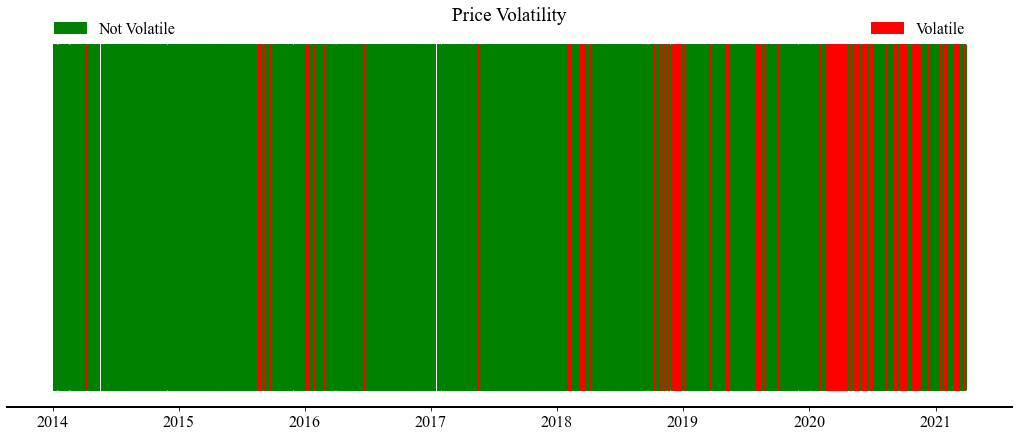

In [46]:
fig, ax = plt.subplots(figsize=(18,7))
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_yticks([])
ax.broken_barh(no_volatile_times, (-1, 1), color='green', label='Not Volatile')
ax.broken_barh(volatile_times, (-1, 1), color='red', label='Volatile')
ax.set_title("Price Volatility")
ax.legend(bbox_to_anchor=(0., .85, 1., .1), loc='lower left', ncol=2, frameon=False, mode="expand", borderaxespad=2.5)
plt.show()

In [47]:
#ax.figure.savefig('Price Volatility.png', dpi=200, transparent=True, bbox_inches='tight')

In [48]:
# This is the pipeline module we need from imblearn for Undersampling
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Adapted from: https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html
names = ["Nearest Neighbors", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost", 
         "Naive Bayes", "QDA", "Logistic Regression", "LightGBM", "XGBoost"]

classifiers = [
    KNeighborsClassifier(3),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression(penalty='l2', max_iter=1000),
    LGBMClassifier(),
    XGBClassifier(use_label_encoder=False)
]

d = {}
cv_scores = {}
acc_scores = {}
f1_scores = {}
f2_scores = {}

# iterate over classifiers
for name, classifier in zip(names, classifiers):
    # Define which resampling method and which ML model to use in the pipeline
    resampling = RandomOverSampler(random_state=SEED)
    #model = RandomForestClassifier(n_estimators=100, criterion='entropy', random_state=0)

    # Define the pipeline and combine sampling method with the model
    pipeline = Pipeline([
        ('Scaler', StandardScaler()),
        ('RandomOverSampling', resampling), 
        ('Model', classifier)
    ])
    start_time = time.time()
    pipeline.fit(X_train, y_train) 
    y_preds = pipeline.predict(X_val)
    runtime = time.time() - start_time
    
    d[name] = y_preds

    # beta > 1 favors recall: TP/(TP+FN) to minimize FN rate
    # False Negative: Predict Negative Volatility, But it actually was Volatilie
    f1_score = fbeta_score(y_val, y_preds, average='weighted', beta=1, zero_division=0)
    f1_scores[name] = [f1_score]
    
    f2_score = fbeta_score(y_val, y_preds, average='weighted', beta=2, zero_division=0)
    f2_scores[name] = [f2_score]
    
    acc_score = accuracy_score(y_val, y_preds)
    acc_scores[name] = [acc_score]
    print(f"{name}'s Accuracy: {acc_score*100:.2f}%, F1 Score: {f1_score*100:.2f}%, F2 Score: {f2_score*100:.2f}%, Runtime: {runtime:.1f} seconds")

Nearest Neighbors's Accuracy: 80.56%, F1 Score: 85.67%, F2 Score: 82.34%, Runtime: 0.0 seconds
Gaussian Process's Accuracy: 90.08%, F1 Score: 90.95%, F2 Score: 90.42%, Runtime: 23.9 seconds
Decision Tree's Accuracy: 51.98%, F1 Score: 64.61%, F2 Score: 54.99%, Runtime: 0.0 seconds
Random Forest's Accuracy: 58.73%, F1 Score: 70.68%, F2 Score: 62.70%, Runtime: 0.0 seconds
Neural Net's Accuracy: 49.60%, F1 Score: 62.74%, F2 Score: 53.06%, Runtime: 2.4 seconds
AdaBoost's Accuracy: 59.52%, F1 Score: 71.02%, F2 Score: 62.57%, Runtime: 0.2 seconds
Naive Bayes's Accuracy: 6.35%, F1 Score: 4.26%, F2 Score: 3.29%, Runtime: 0.0 seconds
QDA's Accuracy: 11.90%, F1 Score: 14.96%, F2 Score: 10.50%, Runtime: 0.0 seconds
Logistic Regression's Accuracy: 25.40%, F1 Score: 35.68%, F2 Score: 26.58%, Runtime: 0.0 seconds
LightGBM's Accuracy: 93.25%, F1 Score: 92.74%, F2 Score: 93.05%, Runtime: 0.1 seconds
[11:14:18] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric use

In [49]:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html#Builtin-styles
# https://stackoverflow.com/questions/29432629/plot-correlation-matrix-using-pandas
corr_ = pd.DataFrame(d).corr().dropna(axis=0, how='all').dropna(axis=1, how='all')
#corr_.style.background_gradient(cmap='coolwarm').set_precision(2)
corr_
# cor(a,b) = cov(a,b)/(stdev(a) * stdev(b))
# If either a or b are all constant (zero variance)
# then correlation between those two are not defined (division by zero producing NaNs). 

Nearest Neighbors  Gaussian Process  Decision Tree  \
Nearest Neighbors               1.0000            0.5661         0.1045   
Gaussian Process                0.5661            1.0000         0.0976   
Decision Tree                   0.1045            0.0976         1.0000   
Random Forest                   0.1303           -0.0053         0.1223   
Neural Net                      0.1182            0.0935         0.1746   
AdaBoost                       -0.0071            0.0440         0.3944   
Naive Bayes                    -0.1594           -0.0796        -0.1423   
QDA                            -0.0882           -0.0393        -0.0718   
Logistic Regression             0.0988            0.0241         0.2182   
LightGBM                        0.0956            0.0457         0.1811   
XGBoost                         0.1552           -0.0471         0.1358   

                     Random Forest  Neural Net  AdaBoost  Naive Bayes     QDA  \
Nearest Neighbors           0.1303      0.1182   -0.0071      -0.1594 -0.0882   
Gaussian Process           -0.0053      0.0935    0.0440      -0.0796 -0.0393   
Decision Tree               0.1223      0.1746    0.3944      -0.1423 -0.0718   
Random Forest               1.0000      0.0445    0.2578      -0.0629 -0.0861   
Neural Net                  0.0445      1.0000    0.3005       0.1446  0.2489   
AdaBoost                    0.2578      0.3005    1.0000       0.1202  0.0218   
Naive Bayes                -0.0629      0.1446    0.1202       1.0000  0.4719   
QDA                        -0.0861      0.2489    0.0218       0.4719  1.0000   
Logistic Regression         0.0768      0.3596    0.2453       0.0591  0.1115   
LightGBM                    0.1359      0.0877    0.1683      -0.1365 -0.0273   
XGBoost                     0.1359      0.1329    0.2142       0.0258 -0.0273   

                     Logistic Regression  LightGBM  XGBoost  
Nearest Neighbors                 0.0988    0.0956   0.1552  
Gaussian Process                  0.0241    0.0457  -0.0471  
Decision Tree                     0.2182    0.1811   0.1358  
Random Forest                     0.0768    0.1359   0.1359  
Neural Net                        0.3596    0.0877   0.1329  
AdaBoost                          0.2453    0.1683   0.2142  
Naive Bayes                       0.0591   -0.1365   0.0258  
QDA                               0.1115   -0.0273  -0.0273  
Logistic Regression               1.0000    0.0979   0.0979  
LightGBM                          0.0979    1.0000   0.3545  
XGBoost                           0.0979    0.3545   1.0000

In this context, False Negative occurs when we predict that there is no Price Volatility ahead but the Price actually became Volatile, and conversely False Positive occurs when we predict the Price is going to be volatile when it actually isn't. Since False Negative is more severe in this case, we use the F2-Score to emphasize more on Recall because we wish to minimize the False Negative Rate. The classifiers are not that correlated with each another, so we build our StackingClassifier based on the F2-Score performance. 

In [50]:
temp = pd.DataFrame(f2_scores).T
temp.rename(columns={0: 'F2'}, inplace=True)
temp.sort_values('F2', ascending=False)

F2
LightGBM            0.9305
XGBoost             0.9223
Gaussian Process    0.9042
Nearest Neighbors   0.8234
Random Forest       0.6270
AdaBoost            0.6257
Decision Tree       0.5499
Neural Net          0.5306
Logistic Regression 0.2658
QDA                 0.1050
Naive Bayes         0.0329

## Stacking Classifier

As the LightGBM Model correlates with XGBoost, we only add LightGBM to the Stack Ensemble

In [51]:
%%time
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
estimators = [
    ( 'lgb', LGBMClassifier() ),
    ( 'knn', KNeighborsClassifier(3) ),
    ( 'gp', GaussianProcessClassifier(1.0 * RBF(1.0)) )
]
classifier = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
pipeline = Pipeline([
    ('Scaler', StandardScaler()),
    ('RandomOverSampling', resampling), 
    ('Model', classifier)
])
pipeline.fit(X_train, y_train) 
y_preds = pipeline.predict(X_val)

Wall time: 1min 33s


In [52]:
f2_score = fbeta_score(y_val, y_preds, average='weighted', beta=2, zero_division=0)
print(f"F2 score: {f2_score*100:.2f}%")

F2 score: 94.45%


The results of stacking marginally improves performance. By Occam's Razor, we choose to finalize the model without stacking parsimoniously, and the final model is a LightGBM Classifier that performed best on our validation set by F2 Score. We now try tuning for hyperparameters to try and improve the test performance.

## Hyperparameter Tuning

We establish the following workflow for Model Validation:
1. Standardization (StandardScaler)
2. Class Imbalance Treatment (RandomOverSampler)
3. Time-series Cross Validation with F2 score
4. Finalize Final Model to predict on Test Set

Our model automatically performs hyperparameter tuning, and automatically fits the model with the best Validation F2-Score

In [53]:
# F2-Scorer
ftwo_scorer = make_scorer(fbeta_score, beta=2, average='weighted')
# https://stackoverflow.com/questions/48390601/explicitly-specifying-test-train-sets-in-gridsearchcv
train_indices = np.arange(0,X_train.shape[0]).tolist()
val_indices = np.arange(X_train.shape[0],train.shape[0]).tolist()
folds = np.repeat([-1, 0], [len(train_indices), len(val_indices)]) # values 0 or positive are kept for validation
cv = PredefinedSplit(folds)
cv.get_n_splits()

1

In [54]:
param_grids = {}
param_grids['Nearest Neighbors'] = {
    'Model__n_neighbors': [3, 5, 10],
    'Model__weights' : ['uniform', 'distance']
}
param_grids['Gaussian Process'] = {
    #'Model__kernel': [1.0 * RBF(1.0), Exponentiation(RationalQuadratic(), exponent=2)]
    'Model__kernel': [1.0 * RBF(1.0)]
}
param_grids['Decision Tree'] = {
    'Model__max_depth': [1, 2, 8, None],
    'Model__min_samples_split': [1, 2, 10],
    'Model__min_samples_leaf': [1, 5, 10]
}
param_grids['Random Forest'] = {
    'Model__n_estimators': [50, 100, 250],
    'Model__min_samples_split': [1, 2, 10],
    'Model__min_samples_leaf': [1, 5, 10],
    'Model__max_depth': [1, 2, 8, None]
}
param_grids['Neural Net'] = {
    'Model__hidden_layer_sizes': [(64, 64), (64,)],
    'Model__alpha': [0.0001, 0.001, 0.01, 1]
}
param_grids['AdaBoost'] = {
    'Model__n_estimators': [15, 50, 150],
    'Model__learning_rate': [0.01, 0.1, 1]
}
param_grids['Naive Bayes'] = {
    'Model__var_smoothing': [1e-9]
}
param_grids['QDA'] = {
    'Model__reg_param': [0.0, 0.01, 0.1, 1, 15]
}
param_grids['Logistic Regression'] = {
    'Model__C': [0.1, 1.0, 5.0]
}
param_grids['LightGBM'] = {
    'Model__learning_rate': [0.01, 0.1, 0.5],
    'Model__n_estimators': [50, 100, 250],
    'Model__lambda_l1': [0.0, 0.01, 0.1],
    'Model__lambda_l2': [0.0, 0.01, 0.1],
    'Model__max_depth': [1, 2, 8, -1]
}
param_grids['XGBoost'] = {
    'Model__max_depth': [1, 2, 6, 8],
    'Model__learning_rate': [0.1, 0.3, 0.6]
}

In [55]:
%%time
# Adapted from: https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html
names = ["Nearest Neighbors", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost", 
         "Naive Bayes", "QDA", "Logistic Regression", "LightGBM", "XGBoost"]

classifiers = [
    KNeighborsClassifier(),
    GaussianProcessClassifier(random_state=SEED),
    DecisionTreeClassifier(random_state=SEED),
    RandomForestClassifier(random_state=SEED),
    MLPClassifier(activation='relu', max_iter=150, shuffle=False, random_state=SEED, early_stopping=True, n_iter_no_change=5),
    AdaBoostClassifier(random_state=SEED),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression(penalty='l2', max_iter=1000),
    LGBMClassifier(),
    XGBClassifier(use_label_encoder=False)
]

cv_scores = {}
best_params = {}
estimators = {}

# iterate over classifiers
for name, classifier in zip(names, classifiers):
    # Define which resampling method and which ML model to use in the pipeline
    resampling = RandomOverSampler(random_state=SEED)
    param_grid = param_grids[name]
    # Define the pipeline and combine sampling method with the model
    pipe = Pipeline([
        ('Scaler', StandardScaler()),
        ('RandomOverSampling', resampling), 
        ('Model', classifier)
    ])
    start_time = time.time()
    clf = GridSearchCV(pipe, param_grid=param_grid, scoring=ftwo_scorer, n_jobs=-1, cv=cv)
    clf.fit(train, train_label)
    estimators[name] = clf.best_estimator_
    best_params[name] = clf.best_params_
    f2_score = clf.best_score_
    cv_scores[name] = [f2_score]
    
    runtime = time.time() - start_time 
    print(f"{name}'s Validation F2 Score: {f2_score*100:.2f}%, Runtime: {runtime:.1f} second(s)")

Nearest Neighbors's Validation F2 Score: 90.20%, Runtime: 2.1 second(s)
Gaussian Process's Validation F2 Score: 93.14%, Runtime: 70.6 second(s)
Decision Tree's Validation F2 Score: 94.75%, Runtime: 1.0 second(s)
Random Forest's Validation F2 Score: 97.62%, Runtime: 6.6 second(s)
Neural Net's Validation F2 Score: 93.14%, Runtime: 1.7 second(s)
AdaBoost's Validation F2 Score: 89.22%, Runtime: 1.0 second(s)
Naive Bayes's Validation F2 Score: 1.63%, Runtime: 0.0 second(s)
QDA's Validation F2 Score: 97.62%, Runtime: 0.0 second(s)
Logistic Regression's Validation F2 Score: 82.24%, Runtime: 0.0 second(s)
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
LightGBM's Validation F2 Score: 97.62%, Runtime: 13.1 second(s)
[11:17:29] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

In [56]:
cross_validation = pd.DataFrame(cv_scores).T
cross_validation.rename(columns={0: 'F2'}, inplace=True)
cross_validation.sort_values('F2', ascending=False)

F2
Random Forest       0.9762
QDA                 0.9762
LightGBM            0.9762
XGBoost             0.9762
Decision Tree       0.9475
Gaussian Process    0.9314
Neural Net          0.9314
Nearest Neighbors   0.9020
AdaBoost            0.8922
Logistic Regression 0.8224
Naive Bayes         0.0163

In [57]:
best_estimator = cross_validation.nlargest(1, columns='F2').index.tolist()[0]
best_estimator

'Random Forest'

In [58]:
final_estimator = estimators[best_estimator]
final_estimator

Pipeline(steps=[('Scaler', StandardScaler()),
                ('RandomOverSampling', RandomOverSampler(random_state=4222)),
                ('Model',
                 RandomForestClassifier(max_depth=8, random_state=4222))])

In [59]:
d = {}
y_scores = {}

# Part 6: Model Evaluation
We finalize our models based on our Validation Workflow above and evaluate the Final models. We fit the final model for three scenarios:
1. Sentiment Features
2. VIX Feature (CBOE close)
3. Sentiment + VIX Features

Our response is the next day closing having a price volatility of 1.5*IQR, and we evaluate based on Accuracy, F1 and F2-score

## Sentiment Features Only

In [60]:
name = 'sentiment only'
final_estimator.fit(train, train_label)
y_preds = final_estimator.predict(X_test)
y_score = final_estimator.predict_proba(X_test)
f1 = fbeta_score(y_test, y_preds, beta=1, average='weighted', zero_division=0)
f2 = fbeta_score(y_test, y_preds, beta=2, average='weighted', zero_division=0)
acc = accuracy_score(y_test, y_preds)
d[name] = {
    'f1': f1,
    'f2': f2,
    'acc': acc
}
y_scores[name] = y_score
print(f"Sentiment Features Only: Accuracy {acc*100:.2f}%, F1-Score: {f1*100:.2f}%, F2-Score: {f2*100:.2f}%")

Sentiment Features Only: Accuracy 61.54%, F1-Score: 60.41%, F2-Score: 61.05%


## VIX Features Only

In [61]:
vix = pd.read_csv('./data/vix.csv', parse_dates=['Date'], infer_datetime_format=True)
vix = vix.set_index('Date')['Close']
vix

Date
2013-12-31   13.7200
2014-01-02   14.2300
2014-01-03   13.7600
2014-01-06   13.5500
2014-01-07   12.9200
2014-01-08   12.8700
2014-01-09   12.8900
               ...  
2021-03-23   20.3000
2021-03-24   21.2000
2021-03-25   19.8100
2021-03-26   18.8600
2021-03-29   20.7400
2021-03-30   19.6100
2021-03-31   19.4000
Name: Close, Length: 1825, dtype: float64

In [62]:
vix_train = vix[vix.index < pd.Timestamp('2020')]
vix_test = vix[vix.index >= pd.Timestamp('2020')]
print(vix_train.shape, vix_test.shape)

combined_train = pd.merge(vix_train, train, left_index=True, right_index=True)
combined_test = pd.merge(vix_test, X_test, left_index=True, right_index=True)
print(combined_train.shape, combined_test.shape)

(1511,) (314,)
(1488, 18) (312, 18)


In [63]:
final_estimator

Pipeline(steps=[('Scaler', StandardScaler()),
                ('RandomOverSampling', RandomOverSampler(random_state=4222)),
                ('Model',
                 RandomForestClassifier(max_depth=8, random_state=4222))])

In [64]:
name = 'vix only'
final_estimator.fit(combined_train['Close'].values.reshape(-1, 1), train_label)
y_preds = final_estimator.predict(combined_test['Close'].values.reshape(-1, 1))
y_score = final_estimator.predict_proba(combined_test['Close'].values.reshape(-1, 1))
f1 = fbeta_score(y_test, y_preds, beta=1, average='weighted', zero_division=0)
f2 = fbeta_score(y_test, y_preds, beta=2, average='weighted', zero_division=0)
acc = accuracy_score(y_test, y_preds)
d[name] = {
    'f1': f1,
    'f2': f2,
    'acc': acc
}
y_scores[name] = y_score
print(f"VIX Only: Accuracy {acc*100:.2f}%, F1-Score: {f1*100:.2f}%, F2-Score: {f2*100:.2f}%")

VIX Only: Accuracy 66.03%, F1-Score: 58.12%, F2-Score: 62.44%


## Sentiment + VIX Features

In [65]:
name = 'combined'
final_estimator.fit(combined_train, train_label)
y_preds = final_estimator.predict(combined_test)
y_score = final_estimator.predict_proba(combined_test)
f1 = fbeta_score(y_test, y_preds, beta=1, average='weighted', zero_division=0)
f2 = fbeta_score(y_test, y_preds, beta=2, average='weighted', zero_division=0)
acc = accuracy_score(y_test, y_preds)
d[name] = {
    'f1': f1,
    'f2': f2,
    'acc': acc
}
y_scores[name] = y_score
print(f"Combined VIX + Sentiment: Accuracy {acc*100:.2f}%, F1-Score: {f1*100:.2f}%, F2-Score: {f2*100:.2f}%")

Combined VIX + Sentiment: Accuracy 70.51%, F1-Score: 58.64%, F2-Score: 65.15%


## Feature Importance

In [66]:
estimators[best_estimator]

Pipeline(steps=[('Scaler', StandardScaler()),
                ('RandomOverSampling', RandomOverSampler(random_state=4222)),
                ('Model',
                 RandomForestClassifier(max_depth=8, random_state=4222))])

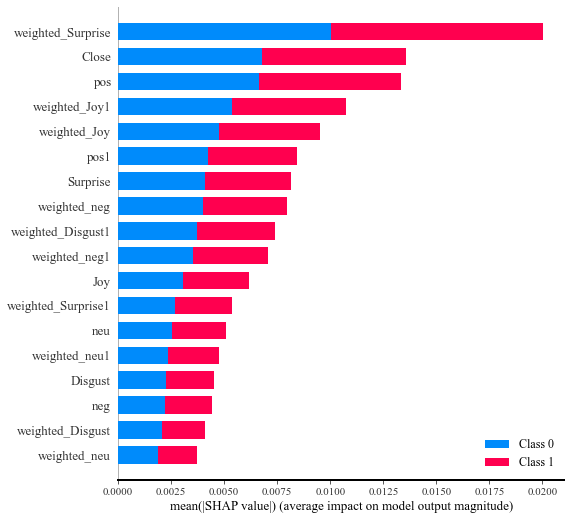

In [67]:
import shap
model = RandomForestClassifier(max_depth=8, n_estimators=50, random_state=SEED)
model.fit(combined_train, train_label)
shap_values = shap.TreeExplainer(model).shap_values(combined_train)
shap.summary_plot(shap_values, combined_train, show=False)
# plt.savefig('shap.png', dpi=200, bbox_inches='tight')

## Evaluation

In [68]:
pd.DataFrame(d)

sentiment only  vix only  combined
acc          0.6154    0.6603    0.7051
f1           0.6041    0.5812    0.5864
f2           0.6105    0.6244    0.6515

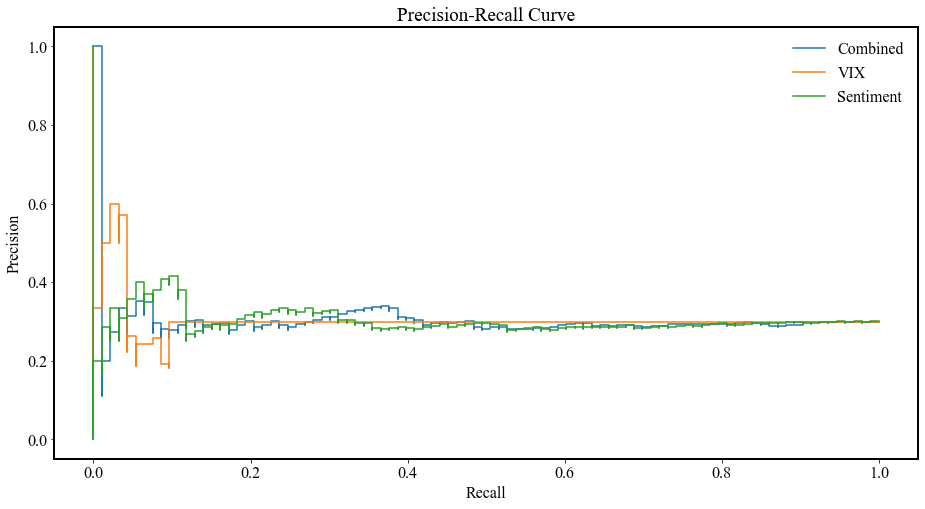

In [69]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_axes([0,0,1,1])
y_score = y_scores['combined']
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score[:,1], pos_label=1)
PrecisionRecallDisplay(precision = precision, recall=recall).plot(ax=ax, label='Combined')
y_score = y_scores['vix only']
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score[:,1], pos_label=1)
PrecisionRecallDisplay(precision = precision, recall=recall).plot(ax=ax, label='VIX')
y_score = y_scores['sentiment only']
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score[:,1], pos_label=1)
PrecisionRecallDisplay(precision = precision, recall=recall).plot(ax=ax, label='Sentiment')
plt.legend(loc='upper right',frameon=False)
plt.title('Precision-Recall Curve')
plt.show()

In [70]:
#ax.figure.savefig('Price Volatility.png', dpi=200, transparent=True, bbox_inches='tight')
#fig.savefig('Precision-Recall.png', dpi=200, transparent=False, bbox_inches='tight')

In [71]:
estimators

{'Nearest Neighbors': Pipeline(steps=[('Scaler', StandardScaler()),
                 ('RandomOverSampling', RandomOverSampler(random_state=4222)),
                 ('Model', KNeighborsClassifier(n_neighbors=3))]),
 'Gaussian Process': Pipeline(steps=[('Scaler', StandardScaler()),
                 ('RandomOverSampling', RandomOverSampler(random_state=4222)),
                 ('Model',
                  GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1),
                                            random_state=4222))]),
 'Decision Tree': Pipeline(steps=[('Scaler', StandardScaler()),
                 ('RandomOverSampling', RandomOverSampler(random_state=4222)),
                 ('Model', DecisionTreeClassifier(random_state=4222))]),
 'Random Forest': Pipeline(steps=[('Scaler', StandardScaler()),
                 ('RandomOverSampling', RandomOverSampler(random_state=4222)),
                 ('Model',
                  RandomForestClassifier(max_depth=8, random_state=4222))]),
 'Ne